In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = pd.read_csv("data/processed/dataConcat_gold.csv")

In [3]:
data.head(5)

,country,iso2,iso3,year,Artificialsurfaces(includingurbanandassociatedareas)_1000HA,Carbonstocksinforests_Milliontonnes,ClimateAlteringLandCoverIndex_Index,Forestarea_1000HA,Grassland_1000HA,Herbaceouscrops_1000HA,...,Landarea_1000HA,Mangroves_1000HA,Permanentsnowandglaciers_1000HA,Shareofforestarea_Percent,Shrub-coveredareas_1000HA,"Shrubsand/orherbaceousvegetation,aquaticorregularlyflooded_1000HA",Sparselynaturalvegetatedareas_1000HA,Terrestrialbarrenland_1000HA,Tree-coveredareas_1000HA,Woodycrops_1000HA
0,"Afghanistan, Islamic Rep. of",AF,AFG,1992,25.32,NaN,98.592188,1208.44,24035.39,5763.35,...,65223.0,0.0,317.57,1.852782,3350.55,5.82,4275.26,24963.00,1263.70,87.43
1,"Afghanistan, Islamic Rep. of",AF,AFG,1993,25.77,NaN,98.699257,1208.44,24035.41,5769.19,...,65223.0,0.0,317.57,1.852782,3350.55,5.82,4275.22,24963.00,1263.79,81.11
2,"Afghanistan, Islamic Rep. of",AF,AFG,1994,26.16,NaN,98.676899,1208.44,24035.44,5767.49,...,65223.0,0.0,317.57,1.852782,3350.54,5.82,4275.22,24963.00,1263.86,82.36
3,"Afghanistan, Islamic Rep. of",AF,AFG,1995,26.69,NaN,98.754703,1208.44,24045.96,5771.52,...,65223.0,0.0,317.57,1.852782,3312.12,5.84,4227.85,25088.58,1241.12,82.96
4,"Afghanistan, Islamic Rep. of",AF,AFG,1996,27.23,NaN,98.995163,1208.44,24044.98,5785.10,...,65223.0,0.0,317.57,1.852782,3306.66,5.92,4220.79,25108.36,1240.82,83.22


In [4]:
data.info()  # Informações sobre colunas, tipos e valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 23 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   country                                                            7194 non-null   object 
 1   iso2                                                               7194 non-null   object 
 2   iso3                                                               7194 non-null   object 
 3   year                                                               7194 non-null   int64  
 4   Artificialsurfaces(includingurbanandassociatedareas)_1000HA        7068 non-null   float64
 5   Carbonstocksinforests_Milliontonnes                                5717 non-null   float64
 6   ClimateAlteringLandCoverIndex_Index                                6977 non-null   float64
 7   Forestarea_1000HA       

In [5]:
data.describe()  # Estatísticas descritivas de colunas numéricas

,year,Artificialsurfaces(includingurbanandassociatedareas)_1000HA,Carbonstocksinforests_Milliontonnes,ClimateAlteringLandCoverIndex_Index,Forestarea_1000HA,Grassland_1000HA,Herbaceouscrops_1000HA,Indexofcarbonstocksinforests_Index,Indexofforestextent_Index,Inlandwaterbodies_1000HA,Landarea_1000HA,Mangroves_1000HA,Permanentsnowandglaciers_1000HA,Shareofforestarea_Percent,Shrub-coveredareas_1000HA,"Shrubsand/orherbaceousvegetation,aquaticorregularlyflooded_1000HA",Sparselynaturalvegetatedareas_1000HA,Terrestrialbarrenland_1000HA,Tree-coveredareas_1000HA,Woodycrops_1000HA
count,7194.000000,7068.000000,5717.000000,6977.000000,6.915000e+03,7068.000000,7068.000000,5659.000000,6884.000000,7068.000000,6.796000e+03,7068.000000,7068.000000,6796.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2006.967612,190.622145,1747.422397,99.694895,2.299156e+04,7602.162930,8216.198980,105.944707,101.116461,1526.035772,5.824902e+04,79.332600,984.177900,33.927982,6801.298912,836.973089,3879.792864,8144.878121,18696.816873,923.647617
std,8.943693,802.744898,6382.910503,35.259589,9.911487e+04,29530.328122,25292.157363,24.015268,17.733373,8191.903770,1.734552e+05,340.713737,11653.462814,24.921772,24214.132767,5738.973996,22059.236024,27951.258773,79797.430121,2941.772399
min,1992.000000,0.000000,0.000000,25.349011,0.000000e+00,0.000000,0.000000,38.861292,35.768354,0.000000,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1999.000000,1.737500,12.410000,96.001943,6.384600e+01,14.210000,10.585000,96.324377,96.383399,7.140000,6.020000e+02,0.000000,0.000000,11.618342,7.027500,0.060000,0.050000,0.000000,37.160000,4.180000
50%,2007.000000,21.405000,153.016800,99.837942,1.901874e+03,501.245000,993.490000,100.000000,100.000000,88.230000,8.824000e+03,0.000000,0.000000,33.133087,215.570000,6.510000,3.550000,2.850000,1252.035000,104.260000
75%,2015.000000,92.295000,802.693000,100.686624,9.417800e+03,3212.232500,5417.967500,108.863618,102.318932,448.090000,4.104500e+04,17.100000,0.000000,52.222222,2305.422500,111.617500,156.835000,416.882500,8355.837500,462.340000
max,2022.000000,11845.390000,58129.141200,740.012265,1.017896e+06,290710.440000,204110.670000,345.808955,296.000000,104146.420000,1.638995e+06,4117.390000,175240.000000,98.002611,202541.920000,87681.500000,284361.000000,209518.260000,955922.990000,32065.460000


In [6]:
data.shape  # Número de linhas e colunas

(7194, 23)

In [7]:
data.columns

Index(['country', 'iso2', 'iso3', 'year',
       'Artificialsurfaces(includingurbanandassociatedareas)_1000HA',
       'Carbonstocksinforests_Milliontonnes',
       'ClimateAlteringLandCoverIndex_Index', 'Forestarea_1000HA',
       'Grassland_1000HA', 'Herbaceouscrops_1000HA',
       'Indexofcarbonstocksinforests_Index', 'Indexofforestextent_Index',
       'Inlandwaterbodies_1000HA', 'Landarea_1000HA', 'Mangroves_1000HA',
       'Permanentsnowandglaciers_1000HA', 'Shareofforestarea_Percent',
       'Shrub-coveredareas_1000HA',
       'Shrubsand/orherbaceousvegetation,aquaticorregularlyflooded_1000HA',
       'Sparselynaturalvegetatedareas_1000HA', 'Terrestrialbarrenland_1000HA',
       'Tree-coveredareas_1000HA', 'Woodycrops_1000HA'],
      dtype='object')

In [8]:
data.isnull().sum()  # Total de valores nulos por coluna

country                                                                 0
iso2                                                                    0
iso3                                                                    0
year                                                                    0
Artificialsurfaces(includingurbanandassociatedareas)_1000HA           126
Carbonstocksinforests_Milliontonnes                                  1477
ClimateAlteringLandCoverIndex_Index                                   217
Forestarea_1000HA                                                     279
Grassland_1000HA                                                      126
Herbaceouscrops_1000HA                                                126
Indexofcarbonstocksinforests_Index                                   1535
Indexofforestextent_Index                                             310
Inlandwaterbodies_1000HA                                              126
Landarea_1000HA                       

In [9]:
data.isnull().mean() * 100  # Percentual de valores nulos por coluna


country                                                               0.000000
iso2                                                                  0.000000
iso3                                                                  0.000000
year                                                                  0.000000
Artificialsurfaces(includingurbanandassociatedareas)_1000HA           1.751460
Carbonstocksinforests_Milliontonnes                                  20.530998
ClimateAlteringLandCoverIndex_Index                                   3.016403
Forestarea_1000HA                                                     3.878232
Grassland_1000HA                                                      1.751460
Herbaceouscrops_1000HA                                                1.751460
Indexofcarbonstocksinforests_Index                                   21.337225
Indexofforestextent_Index                                             4.309147
Inlandwaterbodies_1000HA                            

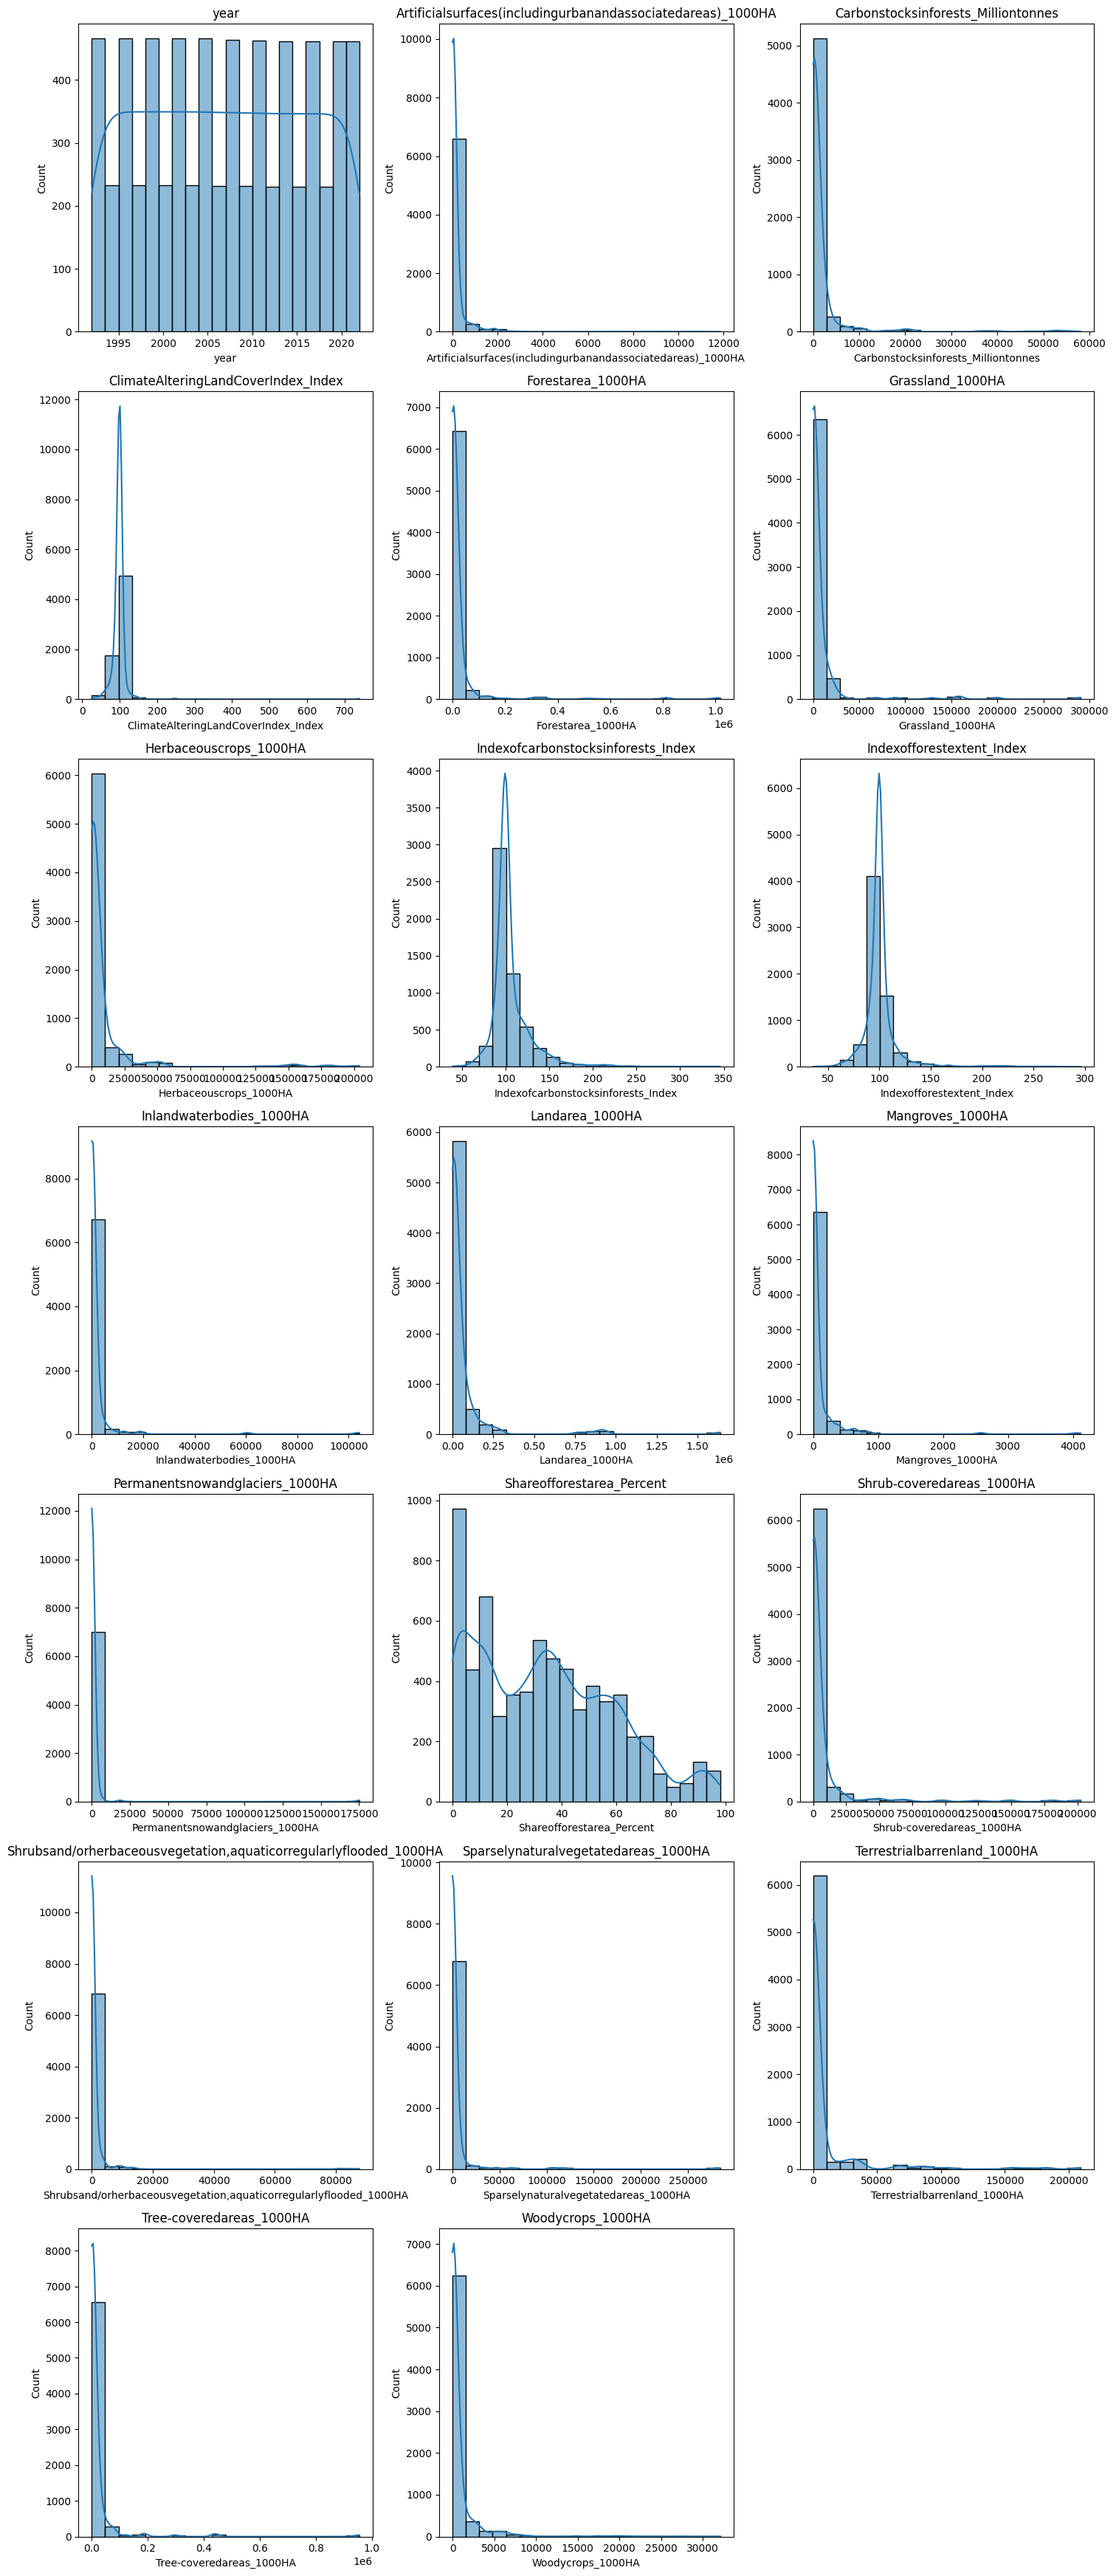

In [10]:
# Histogramas individuais com FacetGrid
import math

num_cols = data.select_dtypes(include=['float64', 'int']).columns  # Apenas colunas numéricas
num_plots = len(num_cols)
cols = 3  # Número de gráficos por linha
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Define o tamanho total
axes = axes.flatten()  # Achata a matriz de eixos

for i, col in enumerate(num_cols):
    sns.histplot(data[col], bins=20, ax=axes[i], kde=True)
    axes[i].set_title(col)
    
# Remove gráficos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


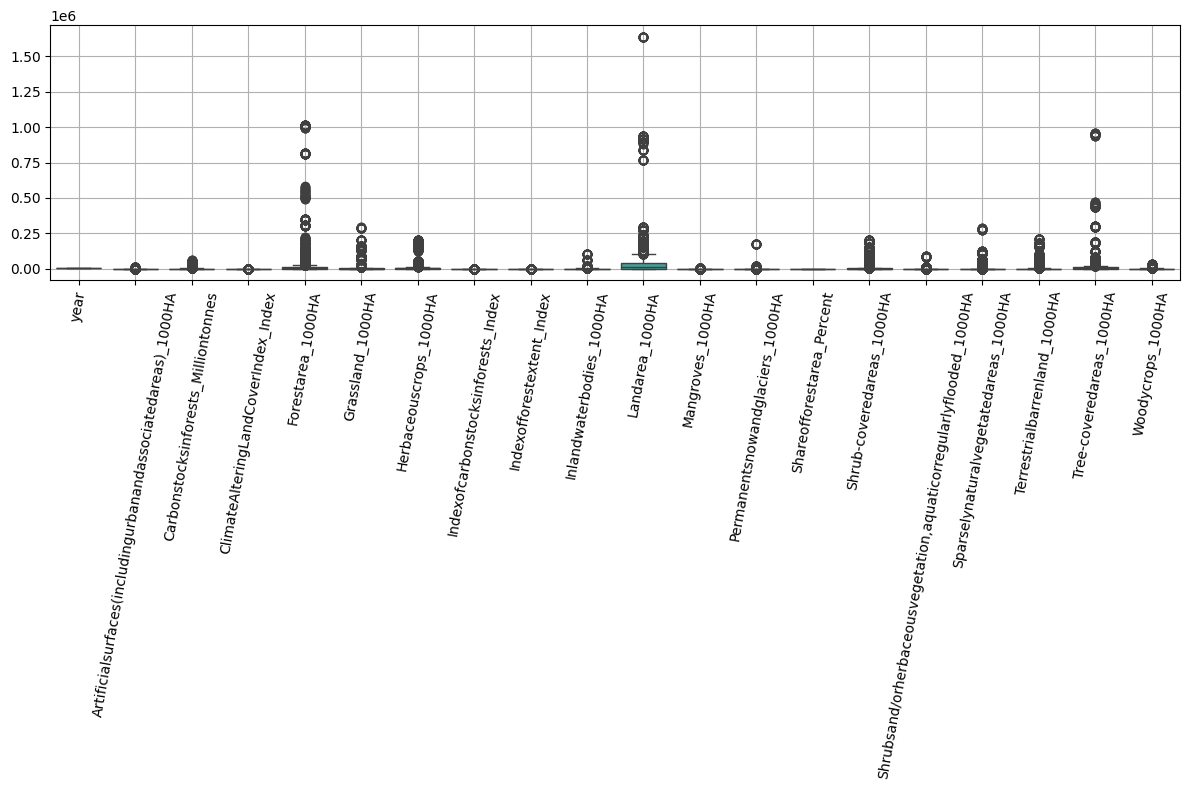

In [11]:
# Rotacionando os rótulos e ajustando o tamanho
plt.figure(figsize=(12, 8))  # Ajusta o tamanho da figura
sns.boxplot(data=data)
plt.xticks(rotation=80)  # Rotaciona os rótulos no eixo X
plt.tight_layout()  # Ajusta o layout
plt.grid()
plt.show()

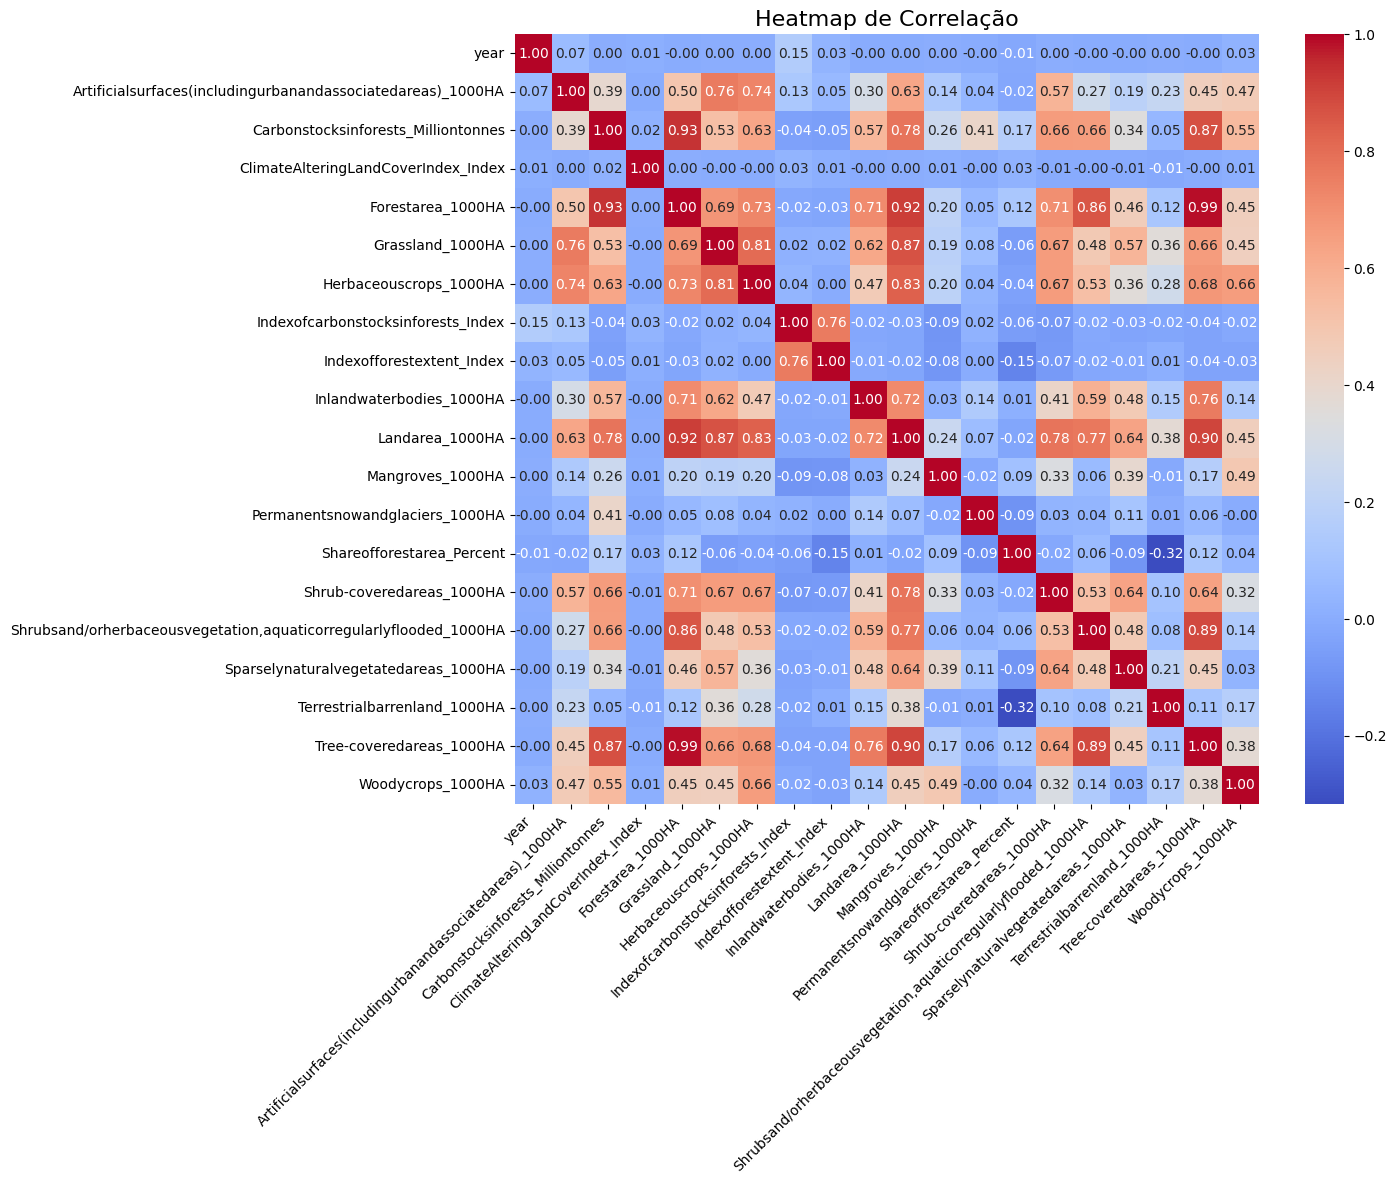

In [14]:
plt.figure(figsize=(12, 10))  # Ajusta o tamanho do gráfico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")  # Reduz para 2 casas decimais
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo X
plt.yticks(rotation=0)  # Mantém os rótulos do eixo Y horizontais
plt.title('Heatmap de Correlação', fontsize=16)  # Adiciona um título
plt.show()